# Zones soumises à un risque d'innondation

### Le but est de trouver les stations ou le niveau d'eau atteint 95% du seuil mis en place.

#### Imports

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from datetime import datetime, timedelta
# Set notebook mode to work in offline
pio.renderers.default = 'iframe+pdf'

#### API STATIONS

On récupères les stations hydrométriques en fonctionnement:

In [2]:
url_stations = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/referentiel/stations"

response_stations = requests.get(url_stations, params={"size": 6000})
if response_stations.status_code == '200' or '206': # status codes are detailed on the website
    data_stations = response_stations.json()
    data_stations = pd.DataFrame(data_stations["data"])
else:
    print(f"La requête a échoué avec le code d'état {response_stations.status_code}")

# We check the names of the columns that contain at least 50% of null values
data_stations.isnull().sum()

# We remove the columns that contain at least 50% of null values
data_stations = data_stations.dropna(axis=1, thresh=int(0.5*len(data_stations)))

# We remove every row that is not in metropolitan france
regions_in_metropolitan_france = ['GRAND EST', 'HAUTS-DE-FRANCE', 'BOURGOGNE-FRANCHE-COMTE', 'ILE-DE-FRANCE', 'CENTRE-VAL DE LOIRE', 'NORMANDIE', 'BRETAGNE', 'PAYS DE LA LOIRE', 'AUVERGNE-RHONE-ALPES', 'OCCITANIE', 'NOUVELLE-AQUITAINE', "PROVENCE-ALPES-COTE D'AZUR", 'CORSE']
data_stations = data_stations[data_stations["libelle_region"].isin(regions_in_metropolitan_france)]

# Next, we remove every row where the corresponding station is not active
data_stations = data_stations[data_stations["en_service"] == True]

# We remove every row where the longitude is between -15 and 40
data_stations = data_stations[(data_stations["longitude_station"] > -15) & (data_stations["longitude_station"] < 40)]

print("Il y a",len(data_stations),"stations en fonctionnement.")

Il y a 3442 stations en fonctionnement.


On sélectionne les stations pour lesquelles on connait le seuil limite (max)

###### Voir code qui a permis de scraper les seuils car pas d'API disponible...

In [3]:
# Les stations dont on a pu récupérer le seuil sont enregistrées dans un fichier txt
with open("stations.txt",'r') as file:
    seuils = {}
    for line in file:
        cle, valeur = line.strip().split(':')        
        seuils[cle] = valeur

code_sites = list(seuils.keys())
print("Il y a",len(seuils),"stations pour lesquelles on a le seuil limite maximum")

Il y a 2778 stations pour lesquelles on a le seuil limite maximum


Visualisation des stations:

In [4]:
data_stations_final = data_stations.loc[data_stations['code_station'].isin(code_sites)]

In [5]:
fig = px.scatter_geo(data_stations_final,lat='latitude_station',lon='longitude_station')
fig.update_layout(title = 'Stations exploitables', title_x=0.5, autosize=True, height=800, geo=dict(
        center=dict(
            lat=46.5,
            lon=2.7274
        ),
        scope='europe',
        projection_scale=6
    ))
fig.show()

On récupère les infos hydrométriques de ces stations. (10 requêtes):

In [6]:
url = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr"
stations = data_stations_final['code_station'].tolist()

date = datetime.now()-timedelta(hours=5)
date = date.strftime("%Y-%m-%dT%H:%M:%S")

date_deb_crue_2016 = datetime(2016, 6, 4)
date_fin_crue_2016 = datetime(2016, 6, 5)

data_hydro = pd.DataFrame()

for i in range(0,len(stations),277):
    params = {
        "code_entite": stations[i:i+277], # station code    
        "date_debut_obs": date,
        #"date_fin_obs": date_fin_crue_2016,
        "grandeur_hydro": ['H'], # hydrometric variables choosen
        "size": 20000
        #"timestep": 20
    }
    
    response = requests.get(url, params=params)
    
    print("status code:",response.status_code)
    
    if response.status_code == (200 or 206): # status codes are detailed on the website
        data = response.json()        
        data_hydro_temp = pd.DataFrame(data["data"])
        data_hydro = pd.concat([data_hydro,data_hydro_temp], ignore_index=True)
    else:
        print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200


On récupère uniquement la dernière observation pour chaque station:

In [7]:
# Convertir la colonne 'date_obs' en type datetime si nécessaire
data_hydro['date_obs'] = pd.to_datetime(data_hydro['date_obs'])

# Trier les données par site et date_obs en ordre décroissant
data_hydro_sorted = data_hydro.sort_values(by=['code_station', 'date_obs'], ascending=[True, False])

# Récupérer les lignes avec les dates les plus récentes pour chaque site
latest_obs_per_site = data_hydro_sorted.groupby('code_station').apply(lambda x: x.loc[x['date_obs'].idxmax()])

# Réinitialiser les index du DataFrame résultant
latest_obs_per_site = latest_obs_per_site.reset_index(drop=True)

Finalement, on regarde les stations dont la hauteur d'eau est à 95% du seuil maximal:

In [8]:
data_hydro_ALERT = pd.DataFrame()
count = 0
for index, row in latest_obs_per_site.iterrows():
    if row['resultat_obs'] > float(seuils[row['code_station']])*0.95:
        data_hydro_ALERT = pd.concat([data_hydro_ALERT,latest_obs_per_site.loc[latest_obs_per_site['code_station']==row['code_station']]],ignore_index=True)

data_hydro_ALERT.head(50)

,code_site,code_station,grandeur_hydro,date_debut_serie,date_fin_serie,statut_serie,code_systeme_alti_serie,date_obs,resultat_obs,code_methode_obs,libelle_methode_obs,code_qualification_obs,libelle_qualification_obs,continuite_obs_hydro,longitude,latitude
0,E3666016,E366601601,H,2023-10-22T00:06:00Z,2023-10-22T21:00:00Z,4,31,2023-10-22 21:00:00+00:00,1344.0,0,Mesure,16,Non qualifiée,True,2.704299,50.637236
1,Y0825411,Y082541101,H,2023-10-22T10:05:00Z,2023-10-22T23:00:00Z,4,31,2023-10-22 23:00:00+00:00,11170.0,0,Mesure,16,Non qualifiée,True,2.956119,43.037344
2,Y0840001,Y084000101,H,2023-10-22T10:05:00Z,2023-10-22T23:00:00Z,4,31,2023-10-22 23:00:00+00:00,16710.0,0,Mesure,16,Non qualifiée,True,2.966740,43.180186
3,Y1612053,Y161205301,H,2023-10-22T00:05:00Z,2023-10-22T23:00:00Z,4,31,2023-10-22 23:00:00+00:00,13680.0,0,Mesure,16,Non qualifiée,True,2.951535,43.254965
4,Y1612054,Y161205401,H,2023-10-22T10:05:00Z,2023-10-22T23:00:00Z,4,31,2023-10-22 23:00:00+00:00,30680.0,0,Mesure,16,Non qualifiée,True,3.078109,43.198333


Visualisation de ces stations:

In [9]:
fig = px.scatter_geo(data_hydro_ALERT,lat='latitude',lon='longitude')
fig.update_layout(title = 'Zones à risque', title_x=0.5, autosize=True, height=800, geo=dict(
        center=dict(
            lat=46.5,
            lon=2.7274
        ),
        scope='europe',
        projection_scale=6
    ))
fig.show()

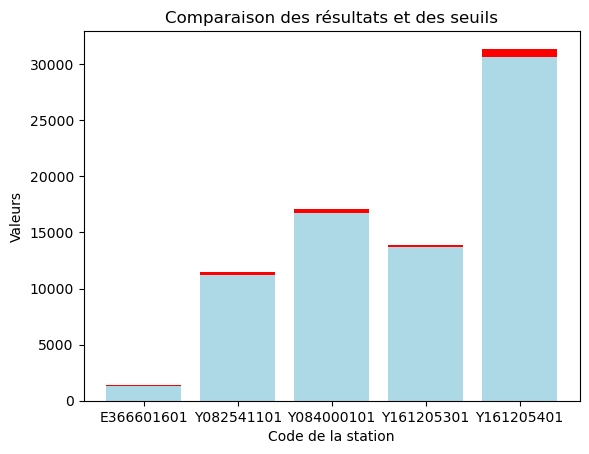

In [10]:
seuils2 = {}
for code in data_hydro_ALERT['code_station']:
    seuils2[code] = seuils[code]
seuils_df = pd.DataFrame.from_dict(seuils2, orient='index', columns=['Seuils']).reset_index()
seuils_df['Seuils'] =seuils_df['Seuils'].astype(int)

plt.bar(seuils_df['index'], seuils_df['Seuils'], color='red')
plt.bar(data_hydro_ALERT['code_station'], data_hydro_ALERT['resultat_obs'], color='lightblue')
plt.title('Comparaison des résultats et des seuils')
plt.xlabel('Code de la station')
plt.ylabel('Valeurs')
plt.show()